# Flu Shot Learning - Machine Learning Final Project

In [1]:
# Utilized data saved in google drive
""" from google.colab import drive
drive.mount('/content/drive') """;

In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Project data in google drive
#DATA_PATH = Path.cwd()/"drive"/"MyDrive"/"APC"/"data";
# Project data from repository
DATA_PATH = Path.cwd()/".."/"data";

features_train = pd.read_csv(
    DATA_PATH/"training_set_features.csv",
    index_col="respondent_id"
)

labels_train = pd.read_csv(
    DATA_PATH/"training_set_labels.csv",
    index_col="respondent_id"
)

np.testing.assert_array_equal(features_train.index.values, labels_train.index.values)

### Logistic Regression Models

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score

RANDOM_SEED = 1337 # Fixed random seed for reproducibility

Initially we'll experiment with a logistic regression model considering only the numerical features variables. For this it is required to apply some processing to the feature set:
- **Scaling**: Transform all features to be on the same scale.
- **NA Imputation**: Logistic regression does not handle NA values (i.e when survey respondents leave out answers unfilled). Median imputation will be utilized, which fills these missing values with the median from the training data.

For a second model, we'll introduce the categorical features. Since these come in the form of string values, encoding is required to make them work within the logistic regression:
- **One-Hot Encoding**: In this form of encoding, different value possibilities within a feature are transformed into new binary variables. This is preferable

# Flu Shot Learning - Machine Learning Final Project

In [50]:
# Just the numerical features
numeric_col_index = features_train.columns[features_train.dtypes != "object"].values
# Categorical features
cat_col_index = features_train.columns[features_train.dtypes == 'object'].values

# Scaling and Imputation steps
numeric_preprocessing = Pipeline([
    ('standard_scaler', StandardScaler()),
    #('min_max_scaler', MinMaxScaler(feature_range=(0,1))),
    ('simpleImputer', SimpleImputer(strategy='median'))
])

categorical_preprocessing = Pipeline([
    ('Imputer', SimpleImputer(strategy='most_frequent')),
    ('Encoding', OneHotEncoder()) # This might not play nice with cat boost``
])

# Apply the preprocessing steps to a given feature column
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_preprocessing, numeric_col_index),
        ("categorical", categorical_preprocessing, cat_col_index),
    ], 
    remainder="drop"
)

# if the CatBoost Classifier is used, the results are better, but as the categorical features are already being encoded to numerical values (in this case One-Hot encoding)

estimators = MultiOutputClassifier(
    #estimator=DummyClassifier(strategy='uniform') # Random classifier for benchmarking
    #estimator=LogisticRegression(penalty="l2", C=10, max_iter=int(1e6), random_state=RANDOM_SEED, class_weight='balanced')
    estimator=CatBoostClassifier(random_seed=RANDOM_SEED)
    #estimator=XGBClassifier(random_state = RANDOM_SEED)
    #estimator=GaussianNB()
    #estimator=MultinomialNB() # has to be used with positive values
    #estimator=DecisionTreeClassifier(criterion='log_loss', splitter='random', class_weight='balanced', random_state=RANDOM_SEED)
    #estimator=KNeighborsClassifier(weights='distance', n_jobs=-1, n_neighbors=169)
)

full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators)
])
full_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('simpleImputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  array(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask',
       'behavioral_wash_hands', 'behavioral_large_gatherings',
       'b...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Encoding',
                                                                   OneHotEncoder())]),
                                                  array(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status',
       'hhs_geo_region', 'census_msa', 'employment_industry',
       'employment_occupation'], dtype=object))])),
                ('estimators',
                 MultiOutputClassifier(estimator=<catboost.core.CatBoostClassifier object at 0x7fcff21af5e0>))])

Searching through several models and parameters using Grid Search CV:
[Multioutput Classifier with grid search](https://stackoverflow.com/questions/71902957/how-to-use-gridsearchcv-with-multioutputclassifiermlpclassifier-pipeline)

In [78]:
#search_space = [{'estimators__estimator': [LogisticRegression(penalty="l2", max_iter=int(1e6), random_state=RANDOM_SEED, class_weight='balanced')], 'estimators__estimator__C': [0.01, 0.1, 1, 10], 'estimators__estimator__penalty': ['l1', 'l2']}]

search_space = [{'estimators__estimator': [KNeighborsClassifier(weights='distance', n_jobs=-1)],
'estimators__estimator__n_neighbors': range(1, 199, 8)},] # step odd numbers

clf = GridSearchCV(estimator=full_pipeline, param_grid=search_space, scoring='roc_auc', verbose=3, n_jobs=-1, cv=10)
clf.fit(features_train, labels_train)

clf.best_estimator_

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV 7/10] END estimators__estimator=KNeighborsClassifier(n_jobs=-1, weights='distance'), estimators__estimator__n_neighbors=1;, score=0.655 total time=   3.0s
[CV 1/10] END estimators__estimator=KNeighborsClassifier(n_jobs=-1, weights='distance'), estimators__estimator__n_neighbors=1;, score=0.646 total time=   3.4s
[CV 2/10] END estimators__estimator=KNeighborsClassifier(n_jobs=-1, weights='distance'), estimators__estimator__n_neighbors=1;, score=0.657 total time=   3.5s
[CV 2/10] END estimators__estimator=KNeighborsClassifier(n_jobs=-1, weights='distance'), estimators__estimator__n_neighbors=9;, score=0.787 total time=   3.3s
[CV 8/10] END estimators__estimator=KNeighborsClassifier(n_jobs=-1, weights='distance'), estimators__estimator__n_neighbors=1;, score=0.656 total time=   3.7s
[CV 3/10] END estimators__estimator=KNeighborsClassifier(n_jobs=-1, weights='distance'), estimators__estimator__n_neighbors=1;, score=0.648 to

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('simpleImputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  array(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask',
       'behavioral_wash_hands', 'behavioral_large_gatherings',
       'b...
                                                                  ('Encoding',
                                                                   OneHotEncoder())]),
                                                  array(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status',
       'hhs_geo_region', 'census_msa', 'employment_industry',
       'employment_occupation'], dtype=object))])),
                ('estimators',
                 MultiOutputClassifier(estimator=KNeighborsClassifier(n_jobs=-1,
                                                                      n_neighbors=169,
                                                                      weights='distance')))])

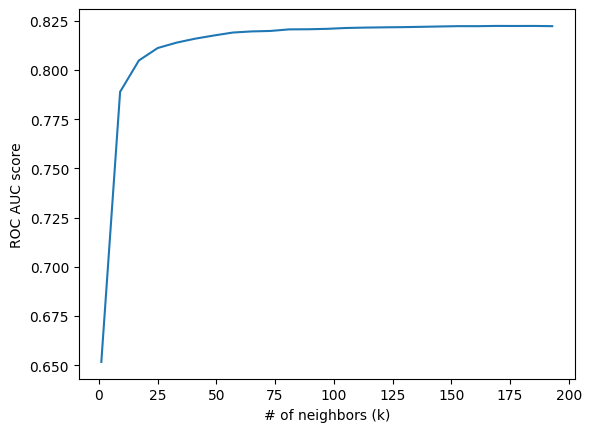

In [84]:
clf.cv_results_['mean_test_score']
clf.param_grid

fig, ax = plt.subplots()

ax.plot(range(1, 199, 8), clf.cv_results_['mean_test_score'])
ax.set_ylabel('ROC AUC score')
ax.set_xlabel('# of neighbors (k)')
plt.show()

#### Training and Evaluation

In [51]:
# Split the training data into two data sets, training and evaluation
X_train, X_eval, y_train, y_eval = train_test_split(
    features_train,
    labels_train,
    test_size=0.25, # 25% of data entries will be used for validation
    shuffle=True,
    stratify=labels_train,
    random_state=RANDOM_SEED
)

# Train the model
full_pipeline.fit(X_train, y_train)
# Evaluate
preds = full_pipeline.predict_proba(X_eval);
#print(preds)

Learning rate set to 0.037047
0:	learn: 0.6674935	total: 60.5ms	remaining: 1m
1:	learn: 0.6440776	total: 66.7ms	remaining: 33.3s
2:	learn: 0.6215596	total: 72.7ms	remaining: 24.1s
3:	learn: 0.6017393	total: 78.1ms	remaining: 19.4s
4:	learn: 0.5847152	total: 83.7ms	remaining: 16.7s
5:	learn: 0.5688834	total: 88.3ms	remaining: 14.6s
6:	learn: 0.5557455	total: 92.5ms	remaining: 13.1s
7:	learn: 0.5423812	total: 96.8ms	remaining: 12s
8:	learn: 0.5301484	total: 101ms	remaining: 11.1s
9:	learn: 0.5182474	total: 105ms	remaining: 10.4s
10:	learn: 0.5080531	total: 110ms	remaining: 9.88s
11:	learn: 0.4990494	total: 112ms	remaining: 9.25s
12:	learn: 0.4912675	total: 118ms	remaining: 8.94s
13:	learn: 0.4832027	total: 122ms	remaining: 8.6s
14:	learn: 0.4755540	total: 126ms	remaining: 8.29s
15:	learn: 0.4686923	total: 131ms	remaining: 8.07s
16:	learn: 0.4624239	total: 136ms	remaining: 7.87s
17:	learn: 0.4566887	total: 140ms	remaining: 7.64s
18:	learn: 0.4511037	total: 144ms	remaining: 7.45s
19:	learn

For the predictions, the pipeline has returned two arrays of predictions, one for each label `seasonal_vaccine` and `h1n1_vaccine`. Within each vector there are two classes, 0 and 1, so we'll only need the values of the second column (which correspond to the probability of having taken the vaccine)

In [52]:
y_preds = pd.DataFrame({
    "h1n1_vaccine": preds[0][:, 1],
    "seasonal_vaccine": preds[1][:, 1],
    #"h1n1_vaccine": preds[:, 0], # for use with decision tree (no predict_proba)
    #"seasonal_vaccine": preds[:, 1],
    },
    index = y_eval.index
)
y_preds.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
8004,0.169559,0.895121
20429,0.150183,0.569414
6634,0.007196,0.008630
9580,0.966424,0.960784
20754,0.120600,0.455463


#### Performance Metrics (ROC)

To measure the performance of the classifications performed between different classifiers, the ROC (Receiver Operating Characteristic) metric was utilized. The ROC is a type of plot used in binary classifiers, which measures the True Positive Rate against the False Positive Rate for different classifier thresholds. To obtain a quantitative measurement of the performance obtained, it it possible to take the area beneath the curve.

0.8506924827864065


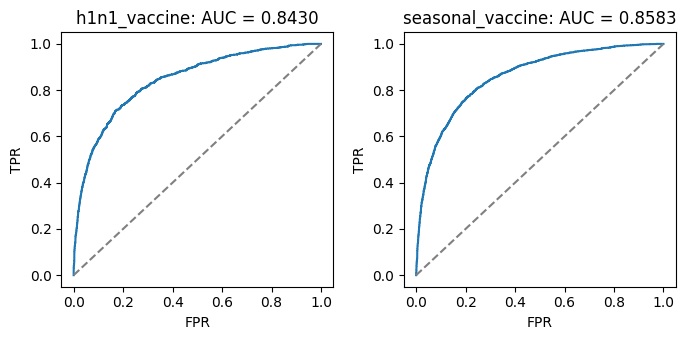

In [53]:
def plot_roc(y_true, y_score, label_name, ax : plt.Axes):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}")

fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine'], 'h1n1_vaccine', ax=ax[0])
plot_roc(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine'], 'seasonal_vaccine', ax=ax[1])
fig.tight_layout()

# Final score,
print(roc_auc_score(y_eval, y_preds))

### Generating predictions for the competition

Before generating predictions for the competition, we'll train the model once again but now using the entire training set.

In [54]:
# Train the model once again using the entire training dataset
#clf.best_estimator_.fit(features_train, labels_train);
full_pipeline.fit(features_train, labels_train);

Learning rate set to 0.041889
0:	learn: 0.6639633	total: 7.78ms	remaining: 7.77s
1:	learn: 0.6367107	total: 14.6ms	remaining: 7.27s
2:	learn: 0.6117068	total: 21.6ms	remaining: 7.17s
3:	learn: 0.5899568	total: 28ms	remaining: 6.97s
4:	learn: 0.5709657	total: 33.3ms	remaining: 6.62s
5:	learn: 0.5536330	total: 39ms	remaining: 6.47s
6:	learn: 0.5380041	total: 43.5ms	remaining: 6.17s
7:	learn: 0.5241781	total: 47.9ms	remaining: 5.94s
8:	learn: 0.5118317	total: 52.5ms	remaining: 5.78s
9:	learn: 0.4999923	total: 57.5ms	remaining: 5.69s
10:	learn: 0.4898403	total: 61.8ms	remaining: 5.56s
11:	learn: 0.4803123	total: 66.2ms	remaining: 5.45s
12:	learn: 0.4719571	total: 70.8ms	remaining: 5.37s
13:	learn: 0.4641524	total: 75.2ms	remaining: 5.3s
14:	learn: 0.4572066	total: 79.8ms	remaining: 5.24s
15:	learn: 0.4510485	total: 84.2ms	remaining: 5.17s
16:	learn: 0.4461485	total: 89.2ms	remaining: 5.16s
17:	learn: 0.4410340	total: 94.3ms	remaining: 5.14s
18:	learn: 0.4364207	total: 98.8ms	remaining: 5.1

In [56]:
from os import makedirs
""" Model should be a class containing a function named predict_proba()
"""
def makeSubmissionCSV(model, outputFilename):
    test_features = pd.read_csv(DATA_PATH / "test_set_features.csv", index_col="respondent_id")
    # Run the competition's test set to generate predictions
    test_probas = model.predict_proba(test_features)

    submission = pd.read_csv(DATA_PATH / "submission_format.csv", index_col = "respondent_id")
    # Verify that the columns are in the right order
    np.testing.assert_array_equal(test_features.index.values,
        submission.index.values)

    # Select the probabilities a person has taken each vaccine
    submission["h1n1_vaccine"] = test_probas[0][:, 1]
    submission["seasonal_vaccine"] = test_probas[1][:, 1]

    makedirs(Path.cwd().parent / "out", exist_ok=True); # create if non-existent
    submission.to_csv(Path.cwd().parent / "out" / outputFilename, index=True)

makeSubmissionCSV(full_pipeline, "cat_submission_NOFEAT.csv")